# findStars

Analyze a star field image and select the brightest stars
This is a python coding of the ideas described in

Diolaiti, E., Bendinelli, O., Bonaccini, D., Close, L., Currie, D., &
Parmeggiani, G. (2000). *Analysis of isoplanatic high resolution stellar fields by the StarFinder code.* **Astronomy and Astrophysics Supplement Series**, 147(2), 335–346. http://doi.org/10.1051/aas:2000305

In [1]:
%matplotlib notebook
import findStars as fs
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astrobot import img
from astrobot.common_units import arcsec,micron

---
## 1. Simulating a star field

For simulation, we start with a random list of $N$ stars, which we've previously generated and placed in a text file starList.txt. Each entry in this list is a 3-element list with $x,y$ field location and a magnitude $m$. The $x$ and $y$ are in rather arbitrary units for now but we can think of them as arcseconds from a field center. They range over a simulated field size, and the field is divided into $n$ "pixels." The "magnitude" is really a brightness in photons rather than an astronomical magnitude. Each field point gets a PSF multiplied by the brightness. The end result is a simulated image of size $n \times n$, composed of

$I(x,y) = \sum_{i=0}^N m_i \times PSF(x-x_i,y-y_i)$


In [2]:
starList = fs.readStarList()


### Atmosphere PSF
The stars are blurred by the atmospheric PSF given by:

$ PSF({\bf x}) = FFT_{{\bf u} \rightarrow {\bf x}} \left\{MTF({\bf u})\right\}; \qquad 
 MTF({\bf u}) = \tau_0(u)\, e^{-{1 \over 2} {\cal D} (u)} $

where ${\bf x}=(x,y)$ is position in the focal plane, ${\bf u} = (u_x,u_y)$ is position on the pupil plane, $u = |{\bf u}|$, $\tau_0(u)$ is the MTF of the telescope,

$ \tau_0(u) = \cos^{-1}(u') u'(1-u'^2)^{1/2} ,\quad u' = u / (D/2) $

and

$ {\cal D}(u) = 6.88 (u/r_0)^{5/3} $

is the structure function of Kolmogorov turbulence,
where $r_0$ is the Fried seeing parameter.


<IPython.core.display.Javascript object>


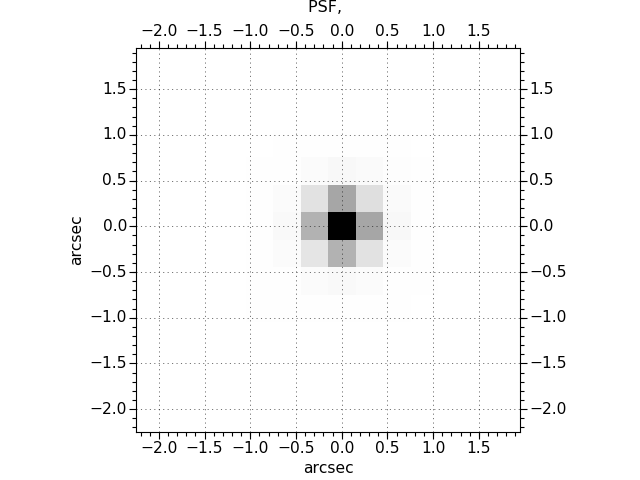

In [3]:
dtheta = 0.3 # arcseconds
n_psf = int(np.round(4./dtheta)) # 4 arcsecond patch
if n_psf%2: n_psf += 1 # make the patch have an even number of pixels
lam = 0.5*micron
seeing = 0.5 # arcsecond
r0 = lam / (seeing*arcsec)
D = 3.0
psf = fs.seeing_psf(n_psf,dtheta,r0=r0,D=D,lam=lam)
psf.show(cmap='Greys')

### Star field
Each field point gets a PSF multiplied by the brightness. The end result is a simulated image of size $n \times n$, composed of

$I(x,y) = \sum_{i=0}^N m_i \times PSF(x-x_i,y-y_i)$


<IPython.core.display.Javascript object>


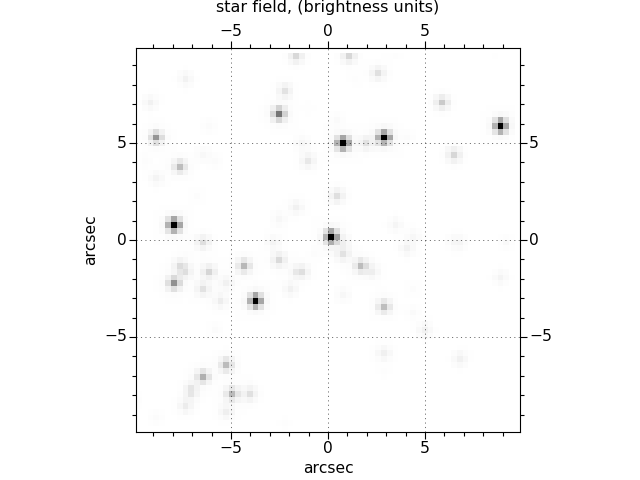

In [4]:
field = fs.simStars(starList, psf, field_size=20)
field.show(cmap='Greys')

Save the field and the PSF for later usage.

In [5]:
import pyfits
hdulist = pyfits.HDUList()
hdulist.append(pyfits.ImageHDU(field))
hdulist.append(pyfits.ImageHDU(psf))
hdulist.writeto('simulated_image.fits',clobber=True)

In [ ]:
field.shape

---
## 2. Finding stars

Now find the brightest stars by first finding the brightest pixels and then finding groups of connected pixels. Identify the groups with labels on the field.

The heart of the group identification, or "blob" identification, is the [scipy.ndimage.label](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.ndimage.label.html#scipy.ndimage.label) routine.

Then, for each blob, the more precise centroid locations of the stars are determined through cross-correlation with the PSF:

$$ C(a,b) = {\overline {(a-\bar a)(b-\bar b)} \, / \, \sigma_a \sigma_b}$$


group 1 - 0.92
group 2 - 0.76
group 3 - 0.89
group 4 - 0.95
group 5 - 0.91
group 6 - 0.78
group 7 - 0.71
group 8 - 0.99
group 9 - 0.94


<IPython.core.display.Javascript object>


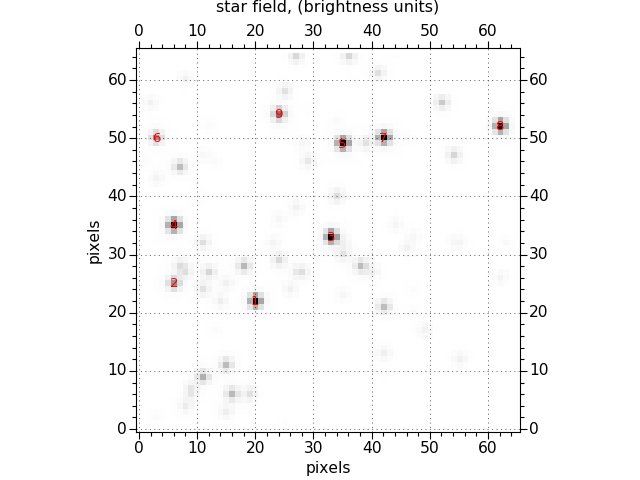

In [7]:
locs,groups = fs.findStars(field,psf,verbose=True,return_groups=True)

# show the data with identified groups
field.show(cmap='Greys')
for index,group in groups:
    xy = (group[0][1],group[0][0])
    s = '%d'%index
    plt.text(xy[0],xy[1],s,color='red',
             verticalalignment='center',horizontalalignment='center')


In the following image, the centroids of the stars are marked with x and the cross-correlation coefficient multiplied by 100.

<IPython.core.display.Javascript object>


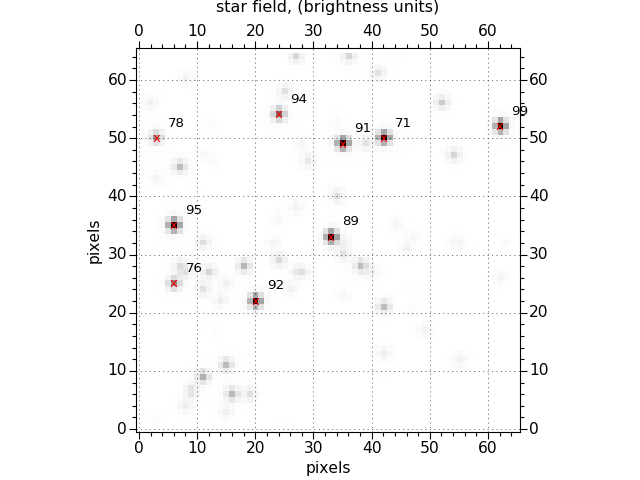

In [8]:
# show the data with the identified center of correlation
field.show(cmap='Greys')
for index,loc,c in locs:
    if loc is not None:
        plt.text(loc[1],loc[0],'x',color='red',
                 verticalalignment='center',horizontalalignment='center')
        s = '%2d'%int(np.round(100*c))
        plt.annotate(s,(loc[1]+2,loc[0]+2))


---
## 3. Removing stars from the original image

Now remove the identified bright stars from the image. This simple approach works okay for isolated stars, where we can assume that $f_i = m  p_i$ for each pixel location $i$. The brightness $m$ is estimated by

$ m_{est} = \frac{\sum_i f_i p_i}{\sum_i p_i^2} $

In [9]:
w1, proc_starlist = fs.removeStars(field, psf, locs)
print '#  (x,  y)   m'
print '----------------'
for num,loc,cc,m in proc_starlist:
    print '%d. (%d, %d), %.2f'%(num,loc[0],loc[1],m)

#  (x,  y)   m
----------------
1. (22, 20), 7.17
2. (25, 6), 3.87
3. (33, 33), 7.34
4. (35, 6), 7.17
5. (49, 35), 7.18
6. (50, 3), 3.63
7. (50, 42), 7.23
8. (52, 62), 7.16
9. (54, 24), 4.45


Here is the star field residual, with the removed stars marked with their index.

<IPython.core.display.Javascript object>


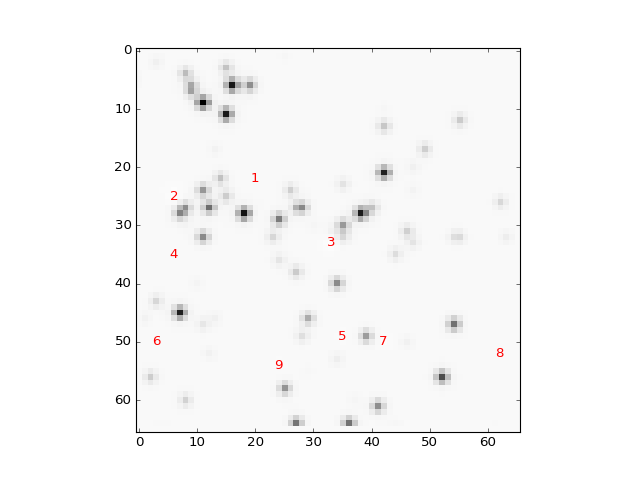

In [11]:

plt.figure()
plt.imshow(w1,interpolation='nearest',cmap='Greys')

for index,loc,c in locs:
    if loc is not None:
        plt.text(loc[1],loc[0],'%d'%index,color='red',
                 verticalalignment='center',horizontalalignment='center')


Repeat the process. At the dimmer magnitudes the star field starts to have source confusion, and the residuals show over subtractions.

<IPython.core.display.Javascript object>


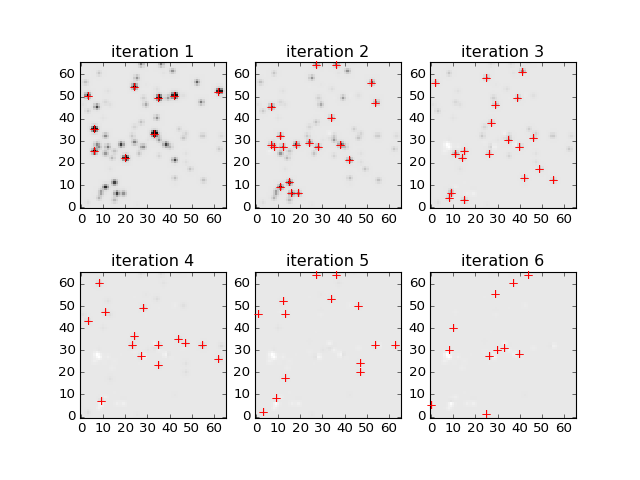

<IPython.core.display.Javascript object>


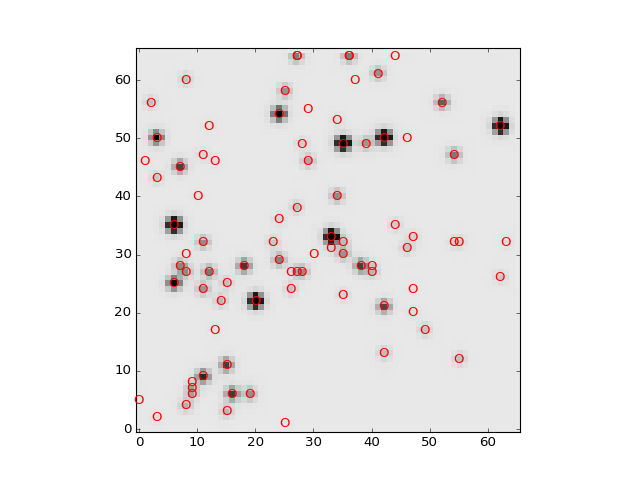

In [12]:
plt.figure()
a = field.max()
w = field.copy()
idstars = []
for i in range(1,7):
    locs,groups = fs.findStars(w,psf,verbose=False,return_groups=True)
    w2, proc_starlist = fs.removeStars(w, psf, locs)
    plt.subplot('23%d'%i)
    plt.title('iteration %d'%i)
    plt.imshow(w,interpolation='nearest',origin='lower',cmap='Greys',vmax=a/2.,vmin=-a/10.)
    for index,loc,c in locs:
        if loc is not None:
            plt.text(loc[1],loc[0],'+',color='red',
                     verticalalignment='center',horizontalalignment='center')
    w = w2
    idstars += proc_starlist

plt.figure()
plt.imshow(field,interpolation='nearest',origin='lower',cmap='Greys',vmax=a/2.,vmin=-a/10.)
for i,xy,cc,m in idstars:
    plt.text(xy[1],xy[0],'O',color='red',
            verticalalignment='center',horizontalalignment='center')
    

In [13]:
import tabulate
print '%d stars identified'%len(idstars)
hdr = ['#','(x,y)','cc','m']
# renumber in order of discovery
tidstars = []
for i,star in zip(range(1,len(idstars)+1),idstars):
    tidstars.append([i,star[1],star[2],star[3]])
print tabulate.tabulate(tidstars,headers=hdr,tablefmt='simple')

86 stars identified
  #  (x,y)            cc           m
---  --------  ---------  ----------
  1  (22, 20)  0.917396    7.16647
  2  (25, 6)   0.756102    3.8669
  3  (33, 33)  0.888049    7.33946
  4  (35, 6)   0.947787    7.16642
  5  (49, 35)  0.907902    7.1833
  6  (50, 3)   0.775788    3.62798
  7  (50, 42)  0.710029    7.22999
  8  (52, 62)  0.994626    7.16423
  9  (54, 24)  0.938308    4.45394
 10  (6, 16)   0.482021    2.87144
 11  (6, 19)   0.314192    1.65989
 12  (9, 11)   0.542152    3.10352
 13  (11, 15)  0.450222    2.73787
 14  (21, 42)  0.855274    2.64627
 15  (27, 8)   0.468015    1.92218
 16  (27, 12)  0.372544    1.98012
 17  (27, 28)  0.599648    1.74759
 18  (28, 7)   0.503364    1.98148
 19  (28, 18)  0.608351    2.80472
 20  (28, 38)  0.666614    2.93176
 21  (29, 24)  0.409607    1.77941
 22  (32, 11)  0.379161    1.56862
 23  (40, 34)  0.734122    1.55517
 24  (45, 7)   0.955179    2.68744
 25  (47, 54)  0.998757    1.85163
 26  (56, 52)  0.994271    2.2702

<IPython.core.display.Javascript object>


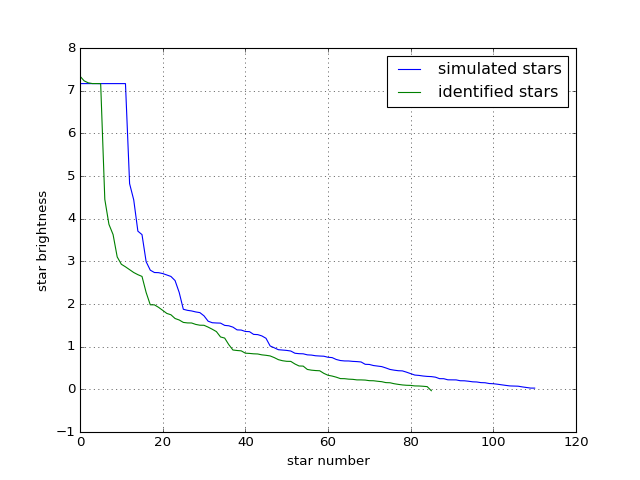

In [14]:
plt.figure()

b = [x[2] for x in starList]
b = sorted(b,reverse=True)
plt.plot(b,label='simulated stars')

m = [x[3] for x in idstars]
m = sorted(m,reverse=True)
plt.plot(m,label='identified stars')

plt.xlabel('star number')
plt.ylabel('star brightness')
plt.grid('on')
plt.legend()

<IPython.core.display.Javascript object>


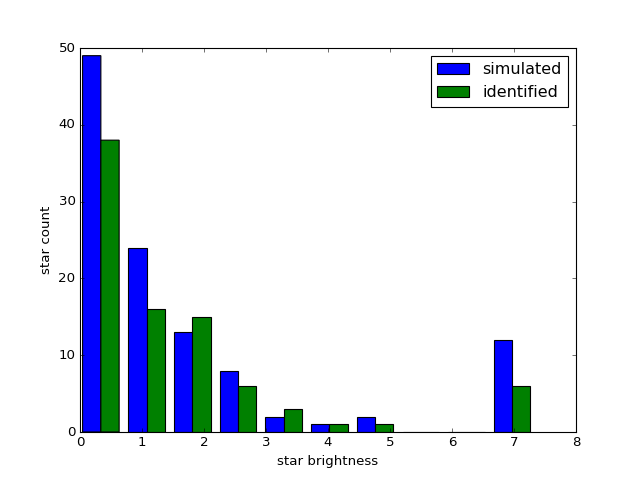

In [15]:
plt.figure()
dum=plt.hist((b,m),label=('simulated','identified'))
plt.xlabel('star brightness')
plt.ylabel('star count')
plt.legend()